In [41]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import sys
from matplotlib.ticker import MaxNLocator


In [42]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
# getHistoParam:
# Nbins, binwidth, bins, counts, bin_centers  = 
from DB_lister import list_content, list_tables
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()
sys.path.append("/groups/icecube/cyan/factory/IceCubeTransformer/Enum/")
from Flavour import Flavour

In [43]:
df_lookup = pd.DataFrame([
    [ "1", "20250518", "152548", 512, 128, 6, 4, 2, "ReLu", "ReLu", "scaled_dot", "Absolute", "A4500"],
    [ "2", "20250518", "153151", 256, 128, 6, 4, 2, "ReLu", "ReLu", "scaled_dot", "Absolute", "A4500"],
    [ "3", "20250518", "233656", 512, 256, 6, 4, 2, "ReLu", "ReLu", "scaled_dot", "Absolute", "A4500"],
    [ "4", "20250518", "233931", 512, 256, 8, 4, 2, "ReLu", "ReLu", "scaled_dot", "Absolute", "A4500"],
    [ "5", "20250518", "172719", 512, 256, 6, 1, 2, "ReLu", "ReLu", "scaled_dot", "Absolute", "A4500"],
    [ "6", "20250518", "172825", 512, 256, 10, 4, 2, "ReLu", "ReLu", "scaled_dot", "Absolute", "A4500"],
    [ "7", "20250518", "174841", 512, 256, 10, 8, 2, "ReLu", "ReLu", "scaled_dot", "Absolute", "A4500"],
    [ "8", "20250518", "174943", 512, 256, 10, 8, 4, "ReLu", "ReLu", "scaled_dot", "Absolute", "A4500"],
    [ "9", "20250518", "235356", 512, 256, 10, 8, 8, "ReLu", "ReLu", "scaled_dot", "Absolute", "A4500"],
    ["10", "20250518", "235535", 512, 256, 10, 8, 8, "GELU", "GELU", "scaled_dot", "Absolute", "A4500"],
    ["11", "20250519", "111436", 512, 256, 10, 8, 8, "SiLU", "SiLU", "scaled_dot", "Absolute", "A4500"],
    ["12", "20250519", "111753", 512, 256, 10, 8, 8, "SiLU", "SiLU", "xformers", "Absolute", "A4500"],
    ["13", "20250519", "112057", 512, 256, 10, 8, 8, "SiLU", "SiLU", "xformers", "ROPE", "A4500"],
    ["14", "20250519", "113232", 512, 256, 10, 8, 8, "SiLU", "SiLU", "AliBi", "AliBi", "A4500"],
    ["15", "20250519", "173628", 512, 256, 10, 8, 8, "SiLU", "SiLU", "T5", "T5", "A4500"],
    ["16", "20250519", "180656", 512, 256, 10, 8, 8, "SiLU", "SiLU", "scaled_dot", "ROPE", "A4500"],
    ["17", "20250521", "121428", 512, 256, 10, 8, 8, "GELU", "SiLU", "scaled_dot", "ROPE", "A4500"],
    ["18", "20250521", "121701", 512, 256, 10, 8, 8, "GELU", "SiLU", "AliBi", "AliBi", "A4500"],
    ["19", "20250521", "122145", 512, 256, 10, 8, 8, "GELU", "SiLU", "T5", "T5", "A4500"],
    ["20", "20250521", "170426", 512, 256, 10, 8, 8, "GELU", "GELU", "T5", "T5", "A4500"],
    ["21", "20250521", "205239", 512, 256, 10, 8, 8, "GELU", "GELU", "scaled_dot", "ROPE", "A4500"],
    ["22", "20250521", "220634", 512, 256, 10, 8, 8, "GELU", "GELU", "AliBi", "AliBi", "A4500"],
    ["23", "20250521", "122145", 512, 256, 10, 8, 8, "GELU", "SiLU", "T5", "T5", "A4500"],
    ["24", "20250521", "122145", 512, 256, 10, 8, 8, "GELU", "SiLU", "T5", "T5", "A4500"],
    ["30", "20250525(32)", "234823", 512, 256, 10, 8, 8, "GELU", "SiLU", "T5", "T5", "A4500"],
    ["40", "20250525(track cascade)", "085820", 512, 256, 10, 8, 8, "GELU", "SiLU", "T5", "T5", "A4500"],
    ["50", "20250526(signal noise)", "172743", 512, 256, 10, 8, 8, "GELU", "SiLU", "T5", "T5", "A4500"],
], columns=[
    "runID","date", "time", "d_model", "seq_len", "n_layers", "n_heads", "n_output_layers",
    "FFNN_activation", "out_activation", "attention", "position_encoding", "GPU"
])


In [44]:
root_dir = os.getcwd()

In [45]:
def load_single_summary(root_dir: str, subdir: str, df_lookup: pd.DataFrame = None) -> pd.DataFrame:
    """
    Load summary.csv from a single subdirectory and merge it with a lookup DataFrame on runID.

    Args:
        root_dir (str): Root directory containing the subdirectory.
        subdir (str): Subdirectory name (e.g., "7").
        df_lookup (pd.DataFrame, optional): Lookup table with config info.

    Returns:
        pd.DataFrame: Loaded and enriched summary dataframe.
    """
    folder_path = os.path.join(root_dir, subdir)
    summary_path = os.path.join(folder_path, "summary.csv")

    if not os.path.exists(summary_path):
        print(f"[⚠️ Missing] {summary_path}")
        return pd.DataFrame()

    try:
        df = pd.read_csv(summary_path)
        if df.isna().any().any():
            print(f"[NaN detected in CSV] {summary_path}")
        df["folder"] = subdir

        # Merge with lookup using runID
        if df_lookup is not None:
            df_lookup = df_lookup.copy()
            df_lookup["runID"] = df_lookup["runID"].astype(str)
            df["runID"] = df["runID"].astype(str)
            df = df.merge(df_lookup, on="runID", how="left")

        # Final NaN check
        if df.isna().any().any():
            missing_cols = df.columns[df.isna().any()].tolist()
            print(f"[NaN detected after merge] in columns: {missing_cols}")

        return df

    except Exception as e:
        print(f"[ERROR] Failed to read {summary_path}: {e}")
        return pd.DataFrame()

In [46]:
load_single_summary(root_dir, "1", df_lookup)

,runID,epoch,num_true_nu_e,AUC_true_nu_e_vs_rest,frac_pred_nu_e_on_true_nu_e_prob_gt_0.9,frac_pred_nu_e_on_true_nu_e_prob_gt_0.8,frac_pred_nu_e_on_true_nu_e_prob_lt_0.2,frac_pred_nu_e_on_true_nu_e_prob_lt_0.1,median_pred_nu_e_on_true_nu_e_prob,frac_pred_nu_mu_on_true_nu_e_prob_gt_0.9,...,d_model,seq_len,n_layers,n_heads,n_output_layers,FFNN_activation,out_activation,attention,position_encoding,GPU
0,1,49,10000,0.787949,0.9745,0.9752,0.0191,0.0173,1.000000,0.3060,...,512,128,6,4,2,ReLu,ReLu,scaled_dot,Absolute,A4500
1,1,12,10000,0.939843,0.7346,0.8428,0.0191,0.0117,0.998945,0.0108,...,512,128,6,4,2,ReLu,ReLu,scaled_dot,Absolute,A4500
2,1,20,10000,0.929321,0.8409,0.8860,0.0255,0.0182,1.000000,0.0215,...,512,128,6,4,2,ReLu,ReLu,scaled_dot,Absolute,A4500
3,1,28,10000,0.906638,0.8845,0.9020,0.0379,0.0306,1.000000,0.0381,...,512,128,6,4,2,ReLu,ReLu,scaled_dot,Absolute,A4500
4,1,24,10000,0.919926,0.8820,0.9065,0.0259,0.0201,1.000000,0.0244,...,512,128,6,4,2,ReLu,ReLu,scaled_dot,Absolute,A4500
5,1,11,10000,0.937305,0.6752,0.7854,0.0317,0.0219,0.985157,0.0063,...,512,128,6,4,2,ReLu,ReLu,scaled_dot,Absolute,A4500
6,1,32,10000,0.869327,0.9601,0.9625,0.0179,0.0144,1.000000,0.1149,...,512,128,6,4,2,ReLu,ReLu,scaled_dot,Absolute,A4500


In [47]:
def load_all_summaries(root_dir: str, df_lookup: pd.DataFrame = None, verbose: bool = True) -> pd.DataFrame:
    """
    Loads all summary.csv files from subdirectories of root_dir and merges with training config info.
    Logs column coverage and detects which subdirs are missing expected columns.

    Args:
        root_dir (str): Root directory containing subdirectories like "7", "8", etc.
        df_lookup (pd.DataFrame, optional): DataFrame containing training config, keyed by 'runID'.
        verbose (bool): Whether to print detailed logs.

    Returns:
        pd.DataFrame: Concatenated summary dataframe with lookup info.
    """
    all_dfs = []
    column_tracker = {}

    for subdir in sorted(os.listdir(root_dir)):
        folder_path = os.path.join(root_dir, subdir)
        if not os.path.isdir(folder_path):
            continue

        df = load_single_summary(root_dir, subdir, df_lookup)
        if not df.empty:
            column_tracker[subdir] = set(df.columns)
            all_dfs.append(df)

    if not all_dfs:
        if verbose:
            print("[INFO] No valid summary files found.")
        return pd.DataFrame()

    full_col_set = set.union(*column_tracker.values())

    if verbose:
        print("\n🔍 Column consistency check:")
        for subdir, cols in column_tracker.items():
            missing = full_col_set - cols
            if missing:
                print(f"[❌] {subdir} is missing: {sorted(missing)}")
            else:
                print(f"[✅] {subdir} has all columns.")

    for df in all_dfs:
        missing_cols = full_col_set - set(df.columns)
        for col in missing_cols:
            df[col] = pd.NA

    df_all = pd.concat(all_dfs, ignore_index=True)

    # Optional: sort if runID and epoch exist
    if "runID" in df_all.columns:
        df_all["runID"] = df_all["runID"].astype(str)
    if "epoch" in df_all.columns:
        df_all["epoch"] = pd.to_numeric(df_all["epoch"], errors='coerce')
        df_all.sort_values(by=["runID", "epoch"], inplace=True)

    if verbose and df_all.isna().any().any():
        missing_cols = df_all.columns[df_all.isna().any()].tolist()
        print(f"\n[❗] NaN values detected in merged dataframe columns: {missing_cols}")

    return df_all


In [48]:
all_summaries = load_all_summaries(root_dir, df_lookup)

[⚠️ Missing] /lustre/hpc/icecube/cyan/factory/IceCubeTransformer/Plot_inference/25/summary.csv
[ERROR] Failed to read /lustre/hpc/icecube/cyan/factory/IceCubeTransformer/Plot_inference/40/summary.csv: No columns to parse from file
[ERROR] Failed to read /lustre/hpc/icecube/cyan/factory/IceCubeTransformer/Plot_inference/50/summary.csv: No columns to parse from file

🔍 Column consistency check:
[✅] 1 has all columns.
[✅] 10 has all columns.
[✅] 11 has all columns.
[✅] 12 has all columns.
[✅] 13 has all columns.
[✅] 14 has all columns.
[✅] 15 has all columns.
[✅] 16 has all columns.
[✅] 17 has all columns.
[✅] 18 has all columns.
[✅] 19 has all columns.
[✅] 2 has all columns.
[✅] 20 has all columns.
[✅] 21 has all columns.
[✅] 22 has all columns.
[✅] 23 has all columns.
[✅] 24 has all columns.
[✅] 3 has all columns.
[✅] 30 has all columns.
[✅] 4 has all columns.
[✅] 5 has all columns.
[✅] 6 has all columns.
[✅] 7 has all columns.
[✅] 8 has all columns.
[✅] 9 has all columns.


In [49]:
all_summaries['runID'].unique()

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '21', '22', '23', '24', '3', '30', '4', '5', '6', '7',
       '8', '9'], dtype=object)

In [50]:
# columns with nan
print(all_summaries.columns[all_summaries.isna().any()].tolist())
print(all_summaries[all_summaries.isna().any(axis=1)])

[]
Empty DataFrame
Columns: [runID, epoch, num_true_nu_e, AUC_true_nu_e_vs_rest, frac_pred_nu_e_on_true_nu_e_prob_gt_0.9, frac_pred_nu_e_on_true_nu_e_prob_gt_0.8, frac_pred_nu_e_on_true_nu_e_prob_lt_0.2, frac_pred_nu_e_on_true_nu_e_prob_lt_0.1, median_pred_nu_e_on_true_nu_e_prob, frac_pred_nu_mu_on_true_nu_e_prob_gt_0.9, frac_pred_nu_mu_on_true_nu_e_prob_gt_0.8, median_pred_nu_mu_on_true_nu_e_prob, frac_pred_nu_tau_on_true_nu_e_prob_gt_0.9, frac_pred_nu_tau_on_true_nu_e_prob_gt_0.8, median_pred_nu_tau_on_true_nu_e_prob, num_true_nu_mu, AUC_true_nu_mu_vs_rest, frac_pred_nu_mu_on_true_nu_mu_prob_gt_0.9, frac_pred_nu_mu_on_true_nu_mu_prob_gt_0.8, frac_pred_nu_mu_on_true_nu_mu_prob_lt_0.2, frac_pred_nu_mu_on_true_nu_mu_prob_lt_0.1, median_pred_nu_mu_on_true_nu_mu_prob, frac_pred_nu_e_on_true_nu_mu_prob_gt_0.9, frac_pred_nu_e_on_true_nu_mu_prob_gt_0.8, median_pred_nu_e_on_true_nu_mu_prob, frac_pred_nu_tau_on_true_nu_mu_prob_gt_0.9, frac_pred_nu_tau_on_true_nu_mu_prob_gt_0.8, median_pred_nu_

In [51]:
# select rows with runID is 9-22
summaries = all_summaries[all_summaries['runID'].astype(int).between(9, 22)]

In [52]:
summaries.shape

(168, 54)

In [53]:
def add_omega_tau_to_df(summaries, purity_fraction: float):
    purity_str = f"{purity_fraction:.1f}"
    impurity_str = f"{1 - purity_fraction:.1f}"
    
    summaries[f"omega_tau_{purity_str}"] = (
        summaries[f"frac_pred_nu_tau_on_true_nu_tau_prob_gt_{purity_str}"]
        - summaries[f"frac_pred_nu_tau_on_true_nu_mu_prob_gt_{purity_str}"]
        - summaries[f"frac_pred_nu_tau_on_true_nu_e_prob_gt_{purity_str}"]
        - summaries[f"frac_pred_nu_tau_on_true_nu_tau_prob_lt_{impurity_str}"]
    )
    return summaries
summaries = add_omega_tau_to_df(summaries, 0.9)
summaries = add_omega_tau_to_df(summaries, 0.8)

/tmp/ipykernel_1097836/1782946978.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summaries[f"omega_tau_{purity_str}"] = (
/tmp/ipykernel_1097836/1782946978.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summaries[f"omega_tau_{purity_str}"] = (


In [54]:
summaries['AUC_true_nu_tau_vs_rest'].describe()

count    168.000000
mean       0.773662
std        0.030242
min        0.663480
25%        0.756609
50%        0.782482
75%        0.796481
max        0.814296
Name: AUC_true_nu_tau_vs_rest, dtype: float64

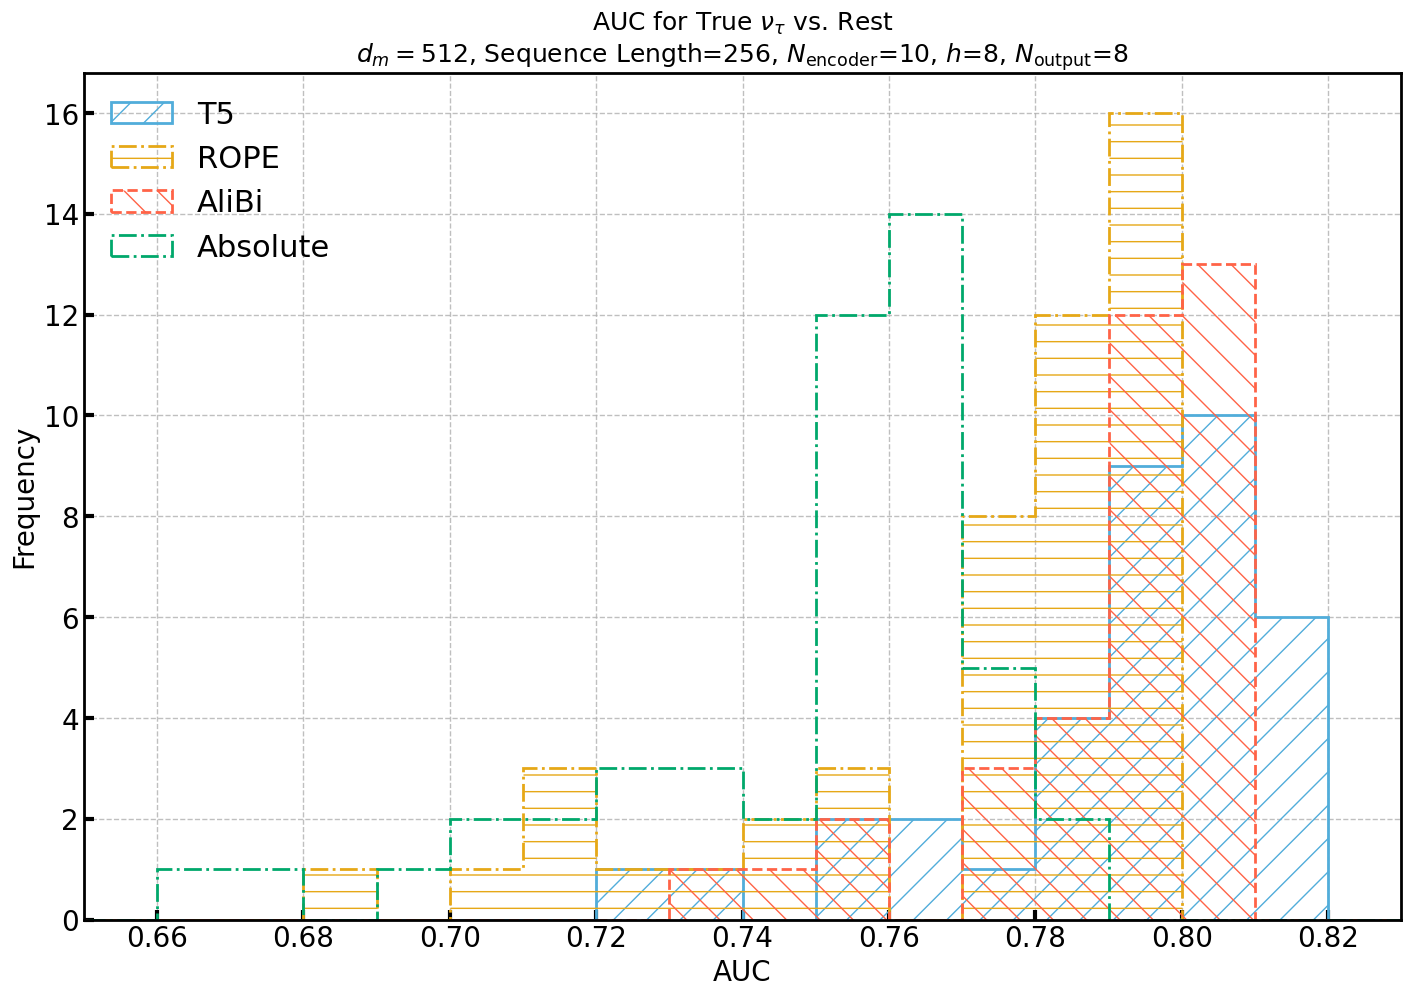

In [55]:
def plot_tau_auc_histogram(summaries):
    auc_tau = summaries['AUC_true_nu_tau_vs_rest']
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(auc_tau.to_numpy(), binwidth=0.01)
    
    auc_tau_t5 = summaries['AUC_true_nu_tau_vs_rest'].loc[summaries['position_encoding'] == 'T5']
    auc_tau_rope = summaries['AUC_true_nu_tau_vs_rest'].loc[summaries['position_encoding'] == 'ROPE']
    auc_tau_alibi = summaries['AUC_true_nu_tau_vs_rest'].loc[summaries['position_encoding'] == 'AliBi']
    auc_tau_abs = summaries['AUC_true_nu_tau_vs_rest'].loc[summaries['position_encoding'] == 'Absolute']
    
    fig, ax = plt.subplots(figsize=(17, 11))
    ax.hist(auc_tau_t5, bins=bins, color=getColour(0), label="T5", histtype='step', lw=2, hatch='/')
    ax.hist(auc_tau_rope, bins=bins, color=getColour(1), label="ROPE", histtype='step', lw=2, hatch='-')
    ax.hist(auc_tau_alibi, bins=bins, color=getColour(2), label="AliBi", histtype='step', lw=2, hatch='\\')
    ax.hist(auc_tau_abs, bins=bins, color=getColour(3), label="Absolute", histtype='step', lw=2)

    # Set labels and title
    ax.set_xlabel("AUC")
    ax.set_ylabel("Frequency")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(
    f"AUC for True ${Flavour.TAU.latex}$ vs. Rest\n"
    "$d_m=512$, Sequence Length=256, $N_{\\text{encoder}}$=10, $h$=8, $N_{\\text{output}}$=8",
    fontsize=18
    )
    ax.set_xlim(0.65, 0.83)
    ax.legend(fontsize=22, loc='upper left', frameon=False)
plot_tau_auc_histogram(summaries)


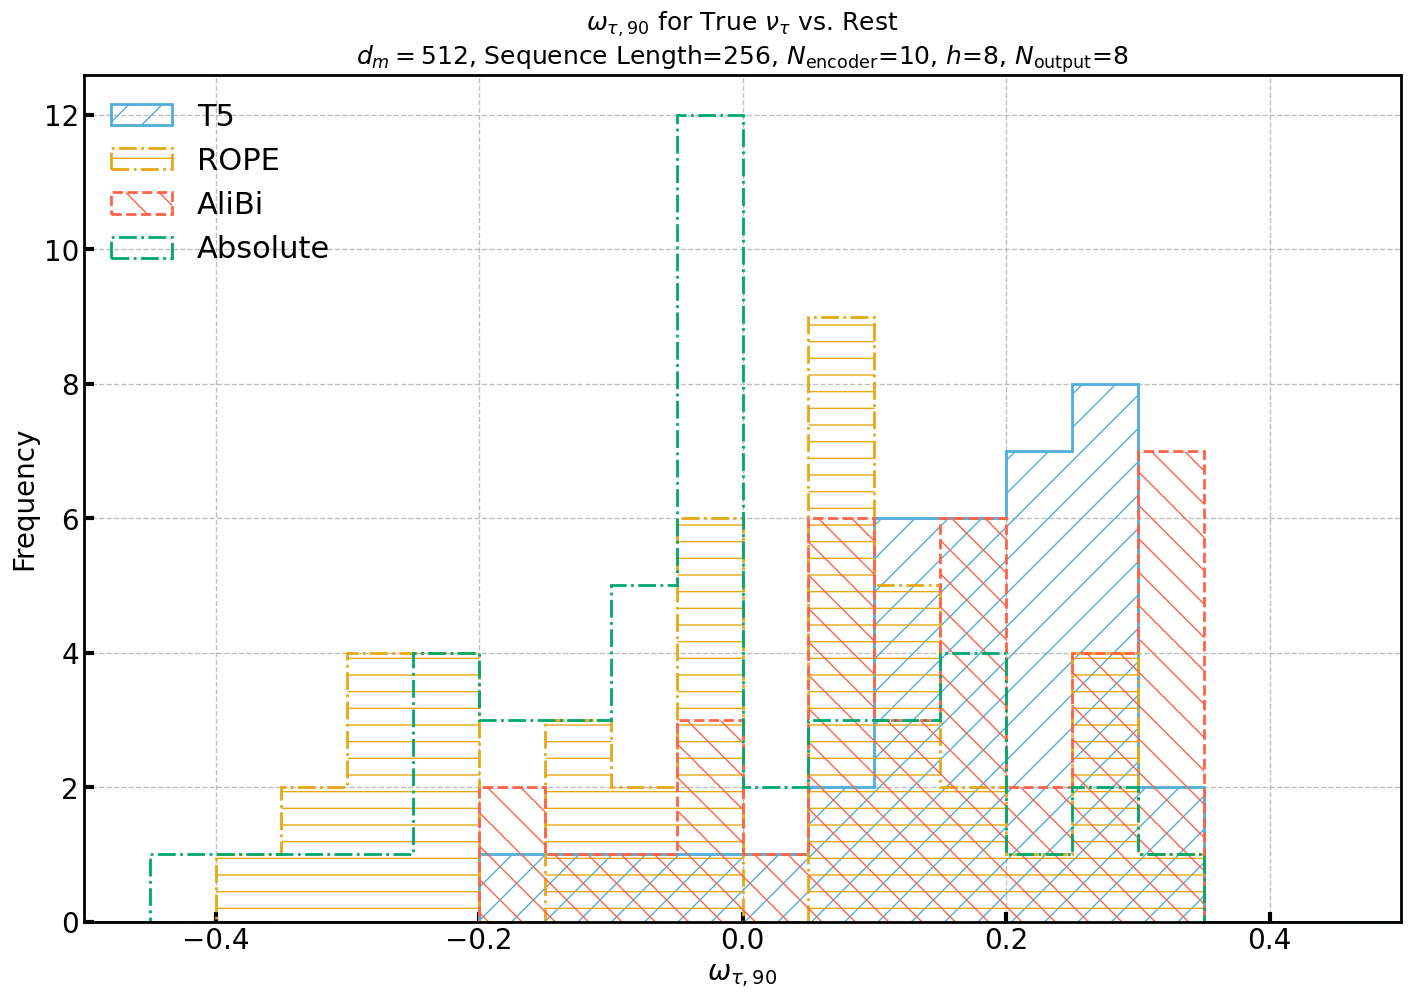

In [56]:
def plot_tau_omega_090_histogram(summaries):
    omega_tau_090 = summaries['omega_tau_0.9']
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(omega_tau_090.to_numpy(), binwidth=0.05)
    
    omega_tau_t5 = summaries['omega_tau_0.9'].loc[summaries['position_encoding'] == 'T5']
    omega_tau_rope = summaries['omega_tau_0.9'].loc[summaries['position_encoding'] == 'ROPE']
    omega_tau_alibi = summaries['omega_tau_0.9'].loc[summaries['position_encoding'] == 'AliBi']
    omega_tau_abs = summaries['omega_tau_0.9'].loc[summaries['position_encoding'] == 'Absolute']
    
    fig, ax = plt.subplots(figsize=(17, 11))
    ax.hist(omega_tau_t5, bins=bins, color=getColour(0), label="T5", histtype='step', lw=2, hatch='/')
    ax.hist(omega_tau_rope, bins=bins, color=getColour(1), label="ROPE", histtype='step', lw=2, hatch='-')
    ax.hist(omega_tau_alibi, bins=bins, color=getColour(2), label="AliBi", histtype='step', lw=2, hatch='\\')
    ax.hist(omega_tau_abs, bins=bins, color=getColour(3), label="Absolute", histtype='step', lw=2)

    # Set labels and title
    ax.set_xlabel(f"$\\omega_{{\\tau, 90}}$")
    ax.set_ylabel("Frequency")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(
        f"$\\omega_{{\\tau, 90}}$ for True ${Flavour.TAU.latex}$ vs. Rest\n"
        "$d_m=512$, Sequence Length=256, $N_{\\text{encoder}}$=10, $h$=8, $N_{\\text{output}}$=8",
        fontsize=18
    )

    ax.set_xlim(-0.5, 0.5)
    ax.legend(fontsize=22, loc='upper left', frameon=False)
plot_tau_omega_090_histogram(summaries)

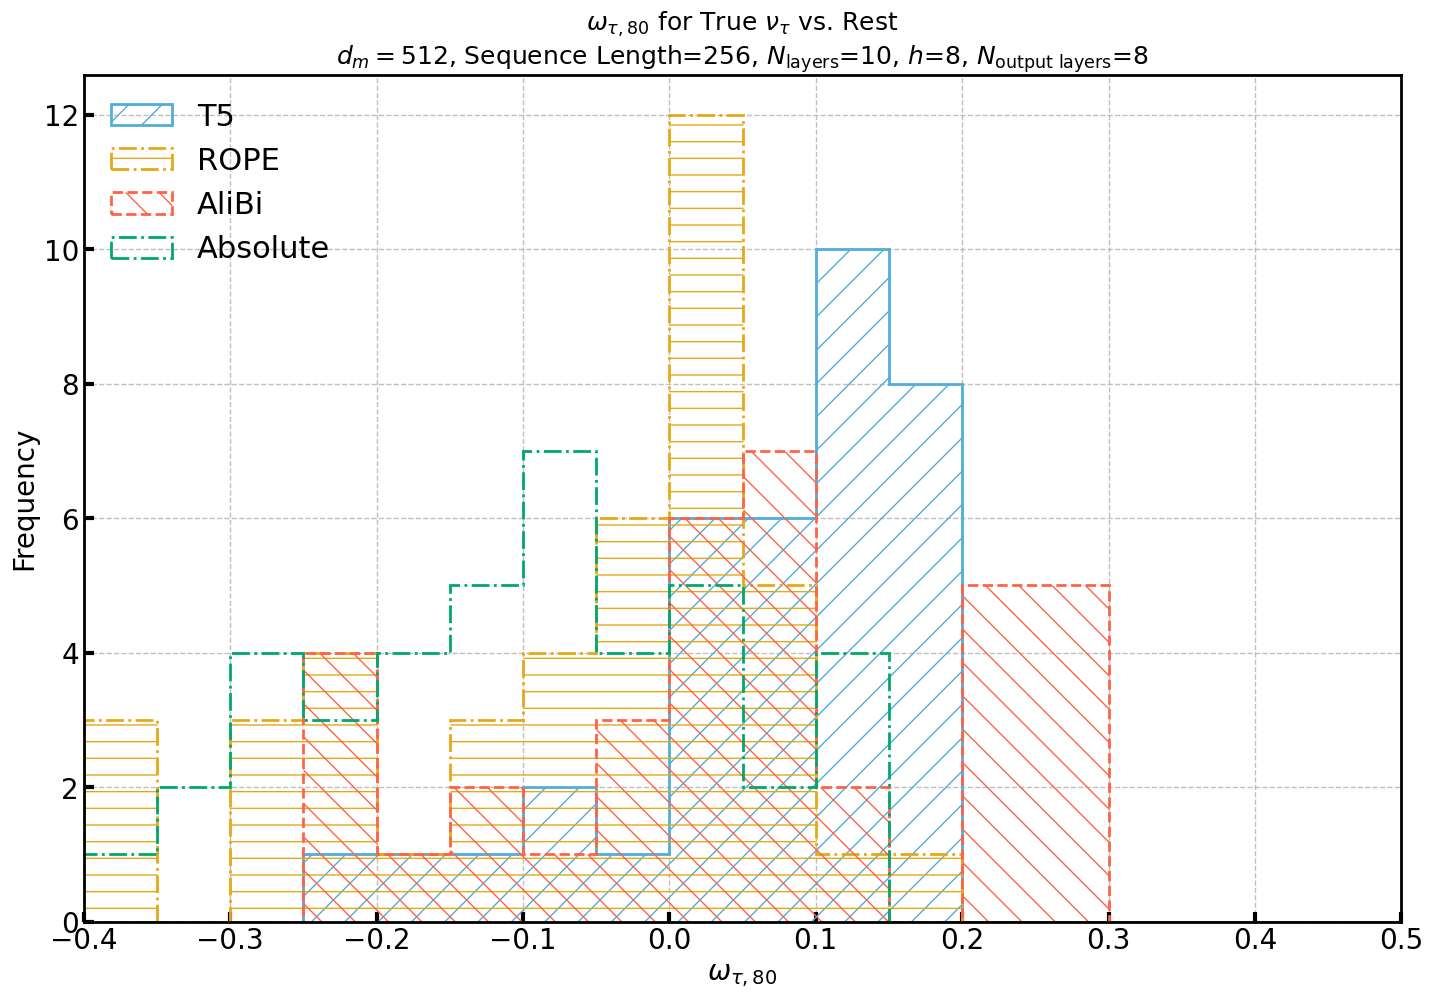

In [ ]:
def plot_tau_omega_080_histogram(summaries):
    omega_tau_080 = summaries['omega_tau_0.8']
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(omega_tau_080.to_numpy(), binwidth=0.05)
    
    omega_tau_t5 = summaries['omega_tau_0.8'].loc[summaries['position_encoding'] == 'T5']
    omega_tau_rope = summaries['omega_tau_0.8'].loc[summaries['position_encoding'] == 'ROPE']
    omega_tau_alibi = summaries['omega_tau_0.8'].loc[summaries['position_encoding'] == 'AliBi']
    omega_tau_abs = summaries['omega_tau_0.8'].loc[summaries['position_encoding'] == 'Absolute']
    
    fig, ax = plt.subplots(figsize=(17, 11))
    ax.hist(omega_tau_t5, bins=bins, color=getColour(0), label="T5", histtype='step', lw=2, hatch='/')
    ax.hist(omega_tau_rope, bins=bins, color=getColour(1), label="ROPE", histtype='step', lw=2, hatch='-')
    ax.hist(omega_tau_alibi, bins=bins, color=getColour(2), label="AliBi", histtype='step', lw=2, hatch='\\')
    ax.hist(omega_tau_abs, bins=bins, color=getColour(3), label="Absolute", histtype='step', lw=2)

    # Set labels and title
    ax.set_xlabel(f"$\\omega_{{\\tau, 80}}$")
    ax.set_ylabel("Frequency")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    ax.set_title(
        f"$\\omega_{{\\tau, 80}}$ for True ${Flavour.TAU.latex}$ vs. Rest\n"
        "$d_m=512$, Sequence Length=256, $N_{\\text{encoder}}$=10, $h$=8, $N_{\\text{output}}$=8",
        fontsize=18
    )

    ax.set_xlim(-0.4, 0.5)
    ax.legend(fontsize=22, loc='upper left', frameon=False)
plot_tau_omega_080_histogram(summaries)

In [58]:
summaries['omega_tau_0.8'].describe()

count    168.000000
mean      -0.050439
std        0.195727
min       -0.634700
25%       -0.156050
50%        0.002500
75%        0.081450
max        0.292300
Name: omega_tau_0.8, dtype: float64

In [59]:
summaries.nlargest(12, 'AUC_true_nu_tau_vs_rest')[['runID','epoch','AUC_true_nu_tau_vs_rest','omega_tau_0.9','omega_tau_0.8','runID','d_model', 'seq_len', 'n_layers', 'n_heads', 'n_output_layers', 'FFNN_activation', 'out_activation', 'attention', 'position_encoding']].sort_values(by='AUC_true_nu_tau_vs_rest', ascending=False).reset_index(drop=True)

,runID,epoch,AUC_true_nu_tau_vs_rest,omega_tau_0.9,omega_tau_0.8,runID,d_model,seq_len,n_layers,n_heads,n_output_layers,FFNN_activation,out_activation,attention,position_encoding
0,19,23,0.814296,0.2395,0.1192,19,512,256,10,8,8,GELU,SiLU,T5,T5
1,19,23,0.814296,0.2395,0.1192,19,512,256,10,8,8,GELU,SiLU,T5,T5
2,19,20,0.813478,0.1612,0.0448,19,512,256,10,8,8,GELU,SiLU,T5,T5
3,19,21,0.812091,0.1739,0.0956,19,512,256,10,8,8,GELU,SiLU,T5,T5
4,19,26,0.812059,0.2687,0.1765,19,512,256,10,8,8,GELU,SiLU,T5,T5
5,20,18,0.811031,0.1861,0.0799,20,512,256,10,8,8,GELU,GELU,T5,T5
6,20,14,0.809597,0.0376,0.1281,20,512,256,10,8,8,GELU,GELU,T5,T5
7,19,19,0.809326,0.0931,0.0263,19,512,256,10,8,8,GELU,SiLU,T5,T5
8,20,13,0.808679,0.1274,0.0822,20,512,256,10,8,8,GELU,GELU,T5,T5
9,18,23,0.808617,0.2236,0.1204,18,512,256,10,8,8,GELU,SiLU,AliBi,AliBi


# Best Composite Fraction

In [60]:
summaries.nlargest(12, 'omega_tau_0.9')[['runID','epoch','AUC_true_nu_tau_vs_rest','omega_tau_0.9','omega_tau_0.8','d_model', 'seq_len', 'n_layers', 'n_heads', 'n_output_layers', 'FFNN_activation', 'out_activation', 'attention', 'position_encoding']].sort_values(by='omega_tau_0.9', ascending=False).reset_index(drop=True)

,runID,epoch,AUC_true_nu_tau_vs_rest,omega_tau_0.9,omega_tau_0.8,d_model,seq_len,n_layers,n_heads,n_output_layers,FFNN_activation,out_activation,attention,position_encoding
0,15,20,0.800533,0.3351,0.1892,512,256,10,8,8,SiLU,SiLU,T5,T5
1,14,29,0.784643,0.3302,0.2404,512,256,10,8,8,SiLU,SiLU,AliBi,AliBi
2,14,24,0.799941,0.3292,0.2923,512,256,10,8,8,SiLU,SiLU,AliBi,AliBi
3,14,18,0.806308,0.3254,0.2602,512,256,10,8,8,SiLU,SiLU,AliBi,AliBi
4,14,23,0.803394,0.3245,0.2596,512,256,10,8,8,SiLU,SiLU,AliBi,AliBi
5,14,23,0.803394,0.3245,0.2596,512,256,10,8,8,SiLU,SiLU,AliBi,AliBi
6,14,32,0.771750,0.3176,0.2311,512,256,10,8,8,SiLU,SiLU,AliBi,AliBi
7,14,26,0.795706,0.3169,0.2647,512,256,10,8,8,SiLU,SiLU,AliBi,AliBi
8,16,32,0.743716,0.3059,0.0588,512,256,10,8,8,SiLU,SiLU,scaled_dot,ROPE
9,9,29,0.732613,0.3039,0.1239,512,256,10,8,8,ReLu,ReLu,scaled_dot,Absolute


In [61]:
summaries.nlargest(12, 'omega_tau_0.8')[['runID','epoch','AUC_true_nu_tau_vs_rest','omega_tau_0.9','omega_tau_0.8','d_model', 'seq_len', 'n_layers', 'n_heads', 'n_output_layers', 'FFNN_activation', 'out_activation', 'attention', 'position_encoding']].sort_values(by='omega_tau_0.8', ascending=False).reset_index(drop=True)

,runID,epoch,AUC_true_nu_tau_vs_rest,omega_tau_0.9,omega_tau_0.8,d_model,seq_len,n_layers,n_heads,n_output_layers,FFNN_activation,out_activation,attention,position_encoding
0,14,24,0.799941,0.3292,0.2923,512,256,10,8,8,SiLU,SiLU,AliBi,AliBi
1,14,26,0.795706,0.3169,0.2647,512,256,10,8,8,SiLU,SiLU,AliBi,AliBi
2,14,18,0.806308,0.3254,0.2602,512,256,10,8,8,SiLU,SiLU,AliBi,AliBi
3,14,23,0.803394,0.3245,0.2596,512,256,10,8,8,SiLU,SiLU,AliBi,AliBi
4,14,23,0.803394,0.3245,0.2596,512,256,10,8,8,SiLU,SiLU,AliBi,AliBi
5,14,16,0.799738,0.2658,0.2497,512,256,10,8,8,SiLU,SiLU,AliBi,AliBi
6,14,17,0.801352,0.2659,0.2440,512,256,10,8,8,SiLU,SiLU,AliBi,AliBi
7,14,29,0.784643,0.3302,0.2404,512,256,10,8,8,SiLU,SiLU,AliBi,AliBi
8,14,32,0.771750,0.3176,0.2311,512,256,10,8,8,SiLU,SiLU,AliBi,AliBi
9,14,20,0.799134,0.2744,0.2302,512,256,10,8,8,SiLU,SiLU,AliBi,AliBi


# Pure High Confidence 

# Worst Composite fraction

In [62]:
summaries.nsmallest(10, 'AUC_true_nu_tau_vs_rest')[['runID','epoch','AUC_true_nu_tau_vs_rest','omega_tau_0.9','omega_tau_0.8','d_model', 'seq_len', 'n_layers', 'n_heads', 'n_output_layers', 'FFNN_activation', 'out_activation', 'attention', 'position_encoding']].sort_values(by='AUC_true_nu_tau_vs_rest', ascending=True).reset_index(drop=True)

,runID,epoch,AUC_true_nu_tau_vs_rest,omega_tau_0.9,omega_tau_0.8,d_model,seq_len,n_layers,n_heads,n_output_layers,FFNN_activation,out_activation,attention,position_encoding
0,11,49,0.663480,-0.3770,-0.6324,512,256,10,8,8,SiLU,SiLU,scaled_dot,Absolute
1,12,49,0.677132,-0.5808,-0.1257,512,256,10,8,8,SiLU,SiLU,xformers,Absolute
2,13,49,0.686176,-0.7908,-0.3556,512,256,10,8,8,SiLU,SiLU,xformers,ROPE
3,11,35,0.695838,-0.3149,-0.5223,512,256,10,8,8,SiLU,SiLU,scaled_dot,Absolute
4,10,49,0.702455,-0.1995,-0.2457,512,256,10,8,8,GELU,GELU,scaled_dot,Absolute
5,21,49,0.705301,-0.2380,-0.2715,512,256,10,8,8,GELU,GELU,scaled_dot,ROPE
6,9,49,0.708548,-0.0362,-0.0501,512,256,10,8,8,ReLu,ReLu,scaled_dot,Absolute
7,13,35,0.710512,-0.7903,-0.4112,512,256,10,8,8,SiLU,SiLU,xformers,ROPE
8,17,49,0.715866,-0.1149,-0.1461,512,256,10,8,8,GELU,SiLU,scaled_dot,ROPE
9,16,49,0.717743,0.2631,-0.1053,512,256,10,8,8,SiLU,SiLU,scaled_dot,ROPE


In [63]:
summaries.nsmallest(10, 'omega_tau_0.9')[['runID','epoch','AUC_true_nu_tau_vs_rest','omega_tau_0.9','omega_tau_0.8','d_model', 'seq_len', 'n_layers', 'n_heads', 'n_output_layers', 'FFNN_activation', 'out_activation', 'attention', 'position_encoding']].sort_values(by='omega_tau_0.9', ascending=True).reset_index(drop=True)

,runID,epoch,AUC_true_nu_tau_vs_rest,omega_tau_0.9,omega_tau_0.8,d_model,seq_len,n_layers,n_heads,n_output_layers,FFNN_activation,out_activation,attention,position_encoding
0,13,49,0.686176,-0.7908,-0.3556,512,256,10,8,8,SiLU,SiLU,xformers,ROPE
1,13,35,0.710512,-0.7903,-0.4112,512,256,10,8,8,SiLU,SiLU,xformers,ROPE
2,12,49,0.677132,-0.5808,-0.1257,512,256,10,8,8,SiLU,SiLU,xformers,Absolute
3,13,32,0.750472,-0.5590,-0.2353,512,256,10,8,8,SiLU,SiLU,xformers,ROPE
4,13,29,0.774240,-0.5025,-0.2384,512,256,10,8,8,SiLU,SiLU,xformers,ROPE
5,12,35,0.737076,-0.4397,-0.1472,512,256,10,8,8,SiLU,SiLU,xformers,Absolute
6,11,49,0.663480,-0.3770,-0.6324,512,256,10,8,8,SiLU,SiLU,scaled_dot,Absolute
7,13,26,0.782784,-0.3635,-0.2055,512,256,10,8,8,SiLU,SiLU,xformers,ROPE
8,21,32,0.737383,-0.3402,-0.3838,512,256,10,8,8,GELU,GELU,scaled_dot,ROPE
9,11,35,0.695838,-0.3149,-0.5223,512,256,10,8,8,SiLU,SiLU,scaled_dot,Absolute


In [64]:
summaries.nsmallest(10, 'omega_tau_0.8')[['runID','epoch','AUC_true_nu_tau_vs_rest','omega_tau_0.9','omega_tau_0.8','d_model', 'seq_len', 'n_layers', 'n_heads', 'n_output_layers', 'FFNN_activation', 'out_activation', 'attention', 'position_encoding']].sort_values(by='omega_tau_0.8', ascending=True).reset_index(drop=True)

,runID,epoch,AUC_true_nu_tau_vs_rest,omega_tau_0.9,omega_tau_0.8,d_model,seq_len,n_layers,n_heads,n_output_layers,FFNN_activation,out_activation,attention,position_encoding
0,12,23,0.763296,-0.2264,-0.6347,512,256,10,8,8,SiLU,SiLU,xformers,Absolute
1,11,49,0.663480,-0.3770,-0.6324,512,256,10,8,8,SiLU,SiLU,scaled_dot,Absolute
2,11,35,0.695838,-0.3149,-0.5223,512,256,10,8,8,SiLU,SiLU,scaled_dot,Absolute
3,11,29,0.717808,-0.2835,-0.5221,512,256,10,8,8,SiLU,SiLU,scaled_dot,Absolute
4,13,11,0.783436,-0.2986,-0.5134,512,256,10,8,8,SiLU,SiLU,xformers,ROPE
5,13,9,0.785986,-0.2805,-0.5129,512,256,10,8,8,SiLU,SiLU,xformers,ROPE
6,13,16,0.792457,-0.2540,-0.4852,512,256,10,8,8,SiLU,SiLU,xformers,ROPE
7,13,8,0.779943,-0.2642,-0.4828,512,256,10,8,8,SiLU,SiLU,xformers,ROPE
8,12,26,0.758269,-0.0853,-0.4757,512,256,10,8,8,SiLU,SiLU,xformers,Absolute
9,12,20,0.766033,-0.2146,-0.4590,512,256,10,8,8,SiLU,SiLU,xformers,Absolute


In [65]:
def sort_df(summary: pd.DataFrame, column: str, n: int, top: bool = True) -> pd.DataFrame:
    
    selected_cols = [
        'runID', 'epoch', 'AUC_true_nu_tau_vs_rest', 'omega_tau_0.9', 'omega_tau_0.8',
        'd_model', 'seq_len', 'n_layers', 'n_heads', 'n_output_layers',
        'FFNN_activation', 'out_activation', 'attention', 'position_encoding'
    ]
    if top:
        df = (
            summary.nlargest(n, column)
            [selected_cols]
            .sort_values(by=column, ascending=False)
            .reset_index(drop=True)
        )
    else:
        df = (
            summary.nsmallest(n, column)
            [selected_cols]
            .sort_values(by=column, ascending=True)
            .reset_index(drop=True)
        )
    
    return df

In [66]:
def generate_latex_table(sorted_df: pd.DataFrame) -> str:
    header = [
        r"\begin{table}[H]",
        r"    \small",
        r"    \centering",
        r"    \makebox[\textwidth][c]{%",
        r"    \begin{tabular}{cclllccccc}",
        r"    \textbf{Train ID} & \textbf{Epoch} & \textbf{AUC$_{\tau}$} & \boldmath$\omega_{\nu_{\tau},90}$ & \boldmath$\omega_{\nu_{\tau},80}$",
        r"    & \textbf{($d_m$, Seq, $N_{\text{encoder}}$, $h$, $N_{\text{output}}$)}",
        r"    & \shortstack{\textbf{FFN} \\ \textbf{Activation}}",
        r"    & \shortstack{\textbf{Output} \\ \textbf{Activation}}",
        r"    & \shortstack{\textbf{Attention} \\ \textbf{Mechanism}}",
        r"    & \shortstack{\textbf{Positional} \\ \textbf{Encoding}} \\",
        r"    \hline\hline"
    ]

    rows = []
    for _, row in sorted_df.iterrows():
        auc = f"{row['AUC_true_nu_tau_vs_rest']:.4f}"
        omega_09 = f"{row['omega_tau_0.9']:.4f}"
        omega_08 = f"{row['omega_tau_0.8']:.4f}"
        arch_tuple = f"({row['d_model']}, {row['seq_len']}, {row['n_layers']}, {row['n_heads']}, {row['n_output_layers']})"
        values = [
            row['runID'], row['epoch'], auc, omega_09, omega_08,
            arch_tuple,
            row['FFNN_activation'], row['out_activation'],
            row['attention'], row['position_encoding']
        ]
        rows.append("    " + " & ".join(map(str, values)) + r"\\")
    
    footer = [
        r"    \hline",
        r"    \end{tabular}}",
        r"    \caption{}",
        rf"    \label{{9:tab:}}",
        r"\end{table}"
    ]

    return "\n".join(header + rows + footer)


In [67]:
print(generate_latex_table(sort_df(summaries, 'AUC_true_nu_tau_vs_rest', 10, True)))

\begin{table}[H]
    \small
    \centering
    \makebox[\textwidth][c]{%
    \begin{tabular}{cclllccccc}
    \textbf{Train ID} & \textbf{Epoch} & \textbf{AUC$_{\tau}$} & \boldmath$\omega_{\nu_{\tau},90}$ & \boldmath$\omega_{\nu_{\tau},80}$
    & \textbf{($d_m$, Seq, $N_{\text{encoder}}$, $h$, $N_{\text{output}}$)}
    & \shortstack{\textbf{FFN} \\ \textbf{Activation}}
    & \shortstack{\textbf{Output} \\ \textbf{Activation}}
    & \shortstack{\textbf{Attention} \\ \textbf{Mechanism}}
    & \shortstack{\textbf{Positional} \\ \textbf{Encoding}} \\
    \hline\hline
    19 & 23 & 0.8143 & 0.2395 & 0.1192 & (512, 256, 10, 8, 8) & GELU & SiLU & T5 & T5\\
    19 & 23 & 0.8143 & 0.2395 & 0.1192 & (512, 256, 10, 8, 8) & GELU & SiLU & T5 & T5\\
    19 & 20 & 0.8135 & 0.1612 & 0.0448 & (512, 256, 10, 8, 8) & GELU & SiLU & T5 & T5\\
    19 & 21 & 0.8121 & 0.1739 & 0.0956 & (512, 256, 10, 8, 8) & GELU & SiLU & T5 & T5\\
    19 & 26 & 0.8121 & 0.2687 & 0.1765 & (512, 256, 10, 8, 8) & GELU & SiLU & T

In [68]:
print(generate_latex_table(sort_df(summaries, 'omega_tau_0.9', 10, True)))

\begin{table}[H]
    \small
    \centering
    \makebox[\textwidth][c]{%
    \begin{tabular}{cclllccccc}
    \textbf{Train ID} & \textbf{Epoch} & \textbf{AUC$_{\tau}$} & \boldmath$\omega_{\nu_{\tau},90}$ & \boldmath$\omega_{\nu_{\tau},80}$
    & \textbf{($d_m$, Seq, $N_{\text{encoder}}$, $h$, $N_{\text{output}}$)}
    & \shortstack{\textbf{FFN} \\ \textbf{Activation}}
    & \shortstack{\textbf{Output} \\ \textbf{Activation}}
    & \shortstack{\textbf{Attention} \\ \textbf{Mechanism}}
    & \shortstack{\textbf{Positional} \\ \textbf{Encoding}} \\
    \hline\hline
    15 & 20 & 0.8005 & 0.3351 & 0.1892 & (512, 256, 10, 8, 8) & SiLU & SiLU & T5 & T5\\
    14 & 29 & 0.7846 & 0.3302 & 0.2404 & (512, 256, 10, 8, 8) & SiLU & SiLU & AliBi & AliBi\\
    14 & 24 & 0.7999 & 0.3292 & 0.2923 & (512, 256, 10, 8, 8) & SiLU & SiLU & AliBi & AliBi\\
    14 & 18 & 0.8063 & 0.3254 & 0.2602 & (512, 256, 10, 8, 8) & SiLU & SiLU & AliBi & AliBi\\
    14 & 23 & 0.8034 & 0.3245 & 0.2596 & (512, 256, 10, 8, 8)

In [69]:
print(generate_latex_table(sort_df(summaries, 'omega_tau_0.8', 10, True)))

\begin{table}[H]
    \small
    \centering
    \makebox[\textwidth][c]{%
    \begin{tabular}{cclllccccc}
    \textbf{Train ID} & \textbf{Epoch} & \textbf{AUC$_{\tau}$} & \boldmath$\omega_{\nu_{\tau},90}$ & \boldmath$\omega_{\nu_{\tau},80}$
    & \textbf{($d_m$, Seq, $N_{\text{encoder}}$, $h$, $N_{\text{output}}$)}
    & \shortstack{\textbf{FFN} \\ \textbf{Activation}}
    & \shortstack{\textbf{Output} \\ \textbf{Activation}}
    & \shortstack{\textbf{Attention} \\ \textbf{Mechanism}}
    & \shortstack{\textbf{Positional} \\ \textbf{Encoding}} \\
    \hline\hline
    14 & 24 & 0.7999 & 0.3292 & 0.2923 & (512, 256, 10, 8, 8) & SiLU & SiLU & AliBi & AliBi\\
    14 & 26 & 0.7957 & 0.3169 & 0.2647 & (512, 256, 10, 8, 8) & SiLU & SiLU & AliBi & AliBi\\
    14 & 18 & 0.8063 & 0.3254 & 0.2602 & (512, 256, 10, 8, 8) & SiLU & SiLU & AliBi & AliBi\\
    14 & 23 & 0.8034 & 0.3245 & 0.2596 & (512, 256, 10, 8, 8) & SiLU & SiLU & AliBi & AliBi\\
    14 & 23 & 0.8034 & 0.3245 & 0.2596 & (512, 256, 10,

In [70]:
exclude_epoch_49 = summaries[summaries['epoch'] != 49]

In [71]:
print(generate_latex_table(sort_df(exclude_epoch_49, 'AUC_true_nu_tau_vs_rest', 5, False)))

\begin{table}[H]
    \small
    \centering
    \makebox[\textwidth][c]{%
    \begin{tabular}{cclllccccc}
    \textbf{Train ID} & \textbf{Epoch} & \textbf{AUC$_{\tau}$} & \boldmath$\omega_{\nu_{\tau},90}$ & \boldmath$\omega_{\nu_{\tau},80}$
    & \textbf{($d_m$, Seq, $N_{\text{encoder}}$, $h$, $N_{\text{output}}$)}
    & \shortstack{\textbf{FFN} \\ \textbf{Activation}}
    & \shortstack{\textbf{Output} \\ \textbf{Activation}}
    & \shortstack{\textbf{Attention} \\ \textbf{Mechanism}}
    & \shortstack{\textbf{Positional} \\ \textbf{Encoding}} \\
    \hline\hline
    11 & 35 & 0.6958 & -0.3149 & -0.5223 & (512, 256, 10, 8, 8) & SiLU & SiLU & scaled_dot & Absolute\\
    13 & 35 & 0.7105 & -0.7903 & -0.4112 & (512, 256, 10, 8, 8) & SiLU & SiLU & xformers & ROPE\\
    11 & 29 & 0.7178 & -0.2835 & -0.5221 & (512, 256, 10, 8, 8) & SiLU & SiLU & scaled_dot & Absolute\\
    11 & 32 & 0.7183 & -0.1975 & -0.3858 & (512, 256, 10, 8, 8) & SiLU & SiLU & scaled_dot & Absolute\\
    9 & 32 & 0.7216 &

In [72]:
print(generate_latex_table(sort_df(exclude_epoch_49, 'omega_tau_0.9', 5, False)))

\begin{table}[H]
    \small
    \centering
    \makebox[\textwidth][c]{%
    \begin{tabular}{cclllccccc}
    \textbf{Train ID} & \textbf{Epoch} & \textbf{AUC$_{\tau}$} & \boldmath$\omega_{\nu_{\tau},90}$ & \boldmath$\omega_{\nu_{\tau},80}$
    & \textbf{($d_m$, Seq, $N_{\text{encoder}}$, $h$, $N_{\text{output}}$)}
    & \shortstack{\textbf{FFN} \\ \textbf{Activation}}
    & \shortstack{\textbf{Output} \\ \textbf{Activation}}
    & \shortstack{\textbf{Attention} \\ \textbf{Mechanism}}
    & \shortstack{\textbf{Positional} \\ \textbf{Encoding}} \\
    \hline\hline
    13 & 35 & 0.7105 & -0.7903 & -0.4112 & (512, 256, 10, 8, 8) & SiLU & SiLU & xformers & ROPE\\
    13 & 32 & 0.7505 & -0.5590 & -0.2353 & (512, 256, 10, 8, 8) & SiLU & SiLU & xformers & ROPE\\
    13 & 29 & 0.7742 & -0.5025 & -0.2384 & (512, 256, 10, 8, 8) & SiLU & SiLU & xformers & ROPE\\
    12 & 35 & 0.7371 & -0.4397 & -0.1472 & (512, 256, 10, 8, 8) & SiLU & SiLU & xformers & Absolute\\
    13 & 26 & 0.7828 & -0.3635 & -0

In [73]:
print(generate_latex_table(sort_df(exclude_epoch_49, 'omega_tau_0.8', 5, False)))

\begin{table}[H]
    \small
    \centering
    \makebox[\textwidth][c]{%
    \begin{tabular}{cclllccccc}
    \textbf{Train ID} & \textbf{Epoch} & \textbf{AUC$_{\tau}$} & \boldmath$\omega_{\nu_{\tau},90}$ & \boldmath$\omega_{\nu_{\tau},80}$
    & \textbf{($d_m$, Seq, $N_{\text{encoder}}$, $h$, $N_{\text{output}}$)}
    & \shortstack{\textbf{FFN} \\ \textbf{Activation}}
    & \shortstack{\textbf{Output} \\ \textbf{Activation}}
    & \shortstack{\textbf{Attention} \\ \textbf{Mechanism}}
    & \shortstack{\textbf{Positional} \\ \textbf{Encoding}} \\
    \hline\hline
    12 & 23 & 0.7633 & -0.2264 & -0.6347 & (512, 256, 10, 8, 8) & SiLU & SiLU & xformers & Absolute\\
    11 & 35 & 0.6958 & -0.3149 & -0.5223 & (512, 256, 10, 8, 8) & SiLU & SiLU & scaled_dot & Absolute\\
    11 & 29 & 0.7178 & -0.2835 & -0.5221 & (512, 256, 10, 8, 8) & SiLU & SiLU & scaled_dot & Absolute\\
    13 & 11 & 0.7834 & -0.2986 & -0.5134 & (512, 256, 10, 8, 8) & SiLU & SiLU & xformers & ROPE\\
    13 & 9 & 0.7860 & -

# Longer Sequence

In [74]:
summaries_long = all_summaries[all_summaries['runID'].astype(int).between(23, 25)]

In [75]:
summaries_long

,runID,epoch,num_true_nu_e,AUC_true_nu_e_vs_rest,frac_pred_nu_e_on_true_nu_e_prob_gt_0.9,frac_pred_nu_e_on_true_nu_e_prob_gt_0.8,frac_pred_nu_e_on_true_nu_e_prob_lt_0.2,frac_pred_nu_e_on_true_nu_e_prob_lt_0.1,median_pred_nu_e_on_true_nu_e_prob,frac_pred_nu_mu_on_true_nu_e_prob_gt_0.9,...,d_model,seq_len,n_layers,n_heads,n_output_layers,FFNN_activation,out_activation,attention,position_encoding,GPU
171,23,17,10000,0.968720,0.2971,0.5649,0.0157,0.0103,0.828660,0.0001,...,512,256,10,8,8,GELU,SiLU,T5,T5,A4500
175,23,17,10000,0.968720,0.2971,0.5649,0.0157,0.0103,0.828660,0.0001,...,512,256,10,8,8,GELU,SiLU,T5,T5,A4500
170,23,19,10000,0.970886,0.4435,0.6696,0.0171,0.0104,0.879471,0.0001,...,512,256,10,8,8,GELU,SiLU,T5,T5,A4500
172,23,20,10000,0.969047,0.4637,0.6650,0.0167,0.0113,0.887088,0.0001,...,512,256,10,8,8,GELU,SiLU,T5,T5,A4500
176,23,21,10000,0.967052,0.3243,0.5480,0.0312,0.0207,0.822754,0.0001,...,512,256,10,8,8,GELU,SiLU,T5,T5,A4500
179,23,23,10000,0.965405,0.1745,0.5529,0.0393,0.0248,0.820758,0.0000,...,512,256,10,8,8,GELU,SiLU,T5,T5,A4500
181,23,23,10000,0.965405,0.1745,0.5529,0.0393,0.0248,0.820758,0.0000,...,512,256,10,8,8,GELU,SiLU,T5,T5,A4500
174,23,26,10000,0.962637,0.2818,0.5169,0.0507,0.0336,0.808592,0.0001,...,512,256,10,8,8,GELU,SiLU,T5,T5,A4500
173,23,29,10000,0.956663,0.3658,0.5851,0.0715,0.0491,0.843643,0.0001,...,512,256,10,8,8,GELU,SiLU,T5,T5,A4500
177,23,32,10000,0.945735,0.3815,0.5631,0.1038,0.0747,0.840909,0.0002,...,512,256,10,8,8,GELU,SiLU,T5,T5,A4500


In [76]:
summaries_long = add_omega_tau_to_df(summaries_long, 0.9)
summaries_long = add_omega_tau_to_df(summaries_long, 0.8)

/tmp/ipykernel_1097836/1782946978.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summaries[f"omega_tau_{purity_str}"] = (
/tmp/ipykernel_1097836/1782946978.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summaries[f"omega_tau_{purity_str}"] = (


In [77]:
# summaries_long

In [78]:
print(generate_latex_table(sort_df(summaries_long, 'AUC_true_nu_tau_vs_rest', 20, True)))

\begin{table}[H]
    \small
    \centering
    \makebox[\textwidth][c]{%
    \begin{tabular}{cclllccccc}
    \textbf{Train ID} & \textbf{Epoch} & \textbf{AUC$_{\tau}$} & \boldmath$\omega_{\nu_{\tau},90}$ & \boldmath$\omega_{\nu_{\tau},80}$
    & \textbf{($d_m$, Seq, $N_{\text{encoder}}$, $h$, $N_{\text{output}}$)}
    & \shortstack{\textbf{FFN} \\ \textbf{Activation}}
    & \shortstack{\textbf{Output} \\ \textbf{Activation}}
    & \shortstack{\textbf{Attention} \\ \textbf{Mechanism}}
    & \shortstack{\textbf{Positional} \\ \textbf{Encoding}} \\
    \hline\hline
    24 & 23 & 0.8362 & 0.3778 & 0.3112 & (512, 256, 10, 8, 8) & GELU & SiLU & T5 & T5\\
    24 & 23 & 0.8362 & 0.3778 & 0.3112 & (512, 256, 10, 8, 8) & GELU & SiLU & T5 & T5\\
    24 & 21 & 0.8355 & 0.3537 & 0.2981 & (512, 256, 10, 8, 8) & GELU & SiLU & T5 & T5\\
    24 & 20 & 0.8348 & 0.3225 & 0.2527 & (512, 256, 10, 8, 8) & GELU & SiLU & T5 & T5\\
    24 & 19 & 0.8332 & 0.2969 & 0.2428 & (512, 256, 10, 8, 8) & GELU & SiLU & T

In [79]:
print(generate_latex_table(sort_df(summaries_long, 'omega_tau_0.9', 20, True)))

\begin{table}[H]
    \small
    \centering
    \makebox[\textwidth][c]{%
    \begin{tabular}{cclllccccc}
    \textbf{Train ID} & \textbf{Epoch} & \textbf{AUC$_{\tau}$} & \boldmath$\omega_{\nu_{\tau},90}$ & \boldmath$\omega_{\nu_{\tau},80}$
    & \textbf{($d_m$, Seq, $N_{\text{encoder}}$, $h$, $N_{\text{output}}$)}
    & \shortstack{\textbf{FFN} \\ \textbf{Activation}}
    & \shortstack{\textbf{Output} \\ \textbf{Activation}}
    & \shortstack{\textbf{Attention} \\ \textbf{Mechanism}}
    & \shortstack{\textbf{Positional} \\ \textbf{Encoding}} \\
    \hline\hline
    24 & 35 & 0.8033 & 0.4474 & 0.3633 & (512, 256, 10, 8, 8) & GELU & SiLU & T5 & T5\\
    24 & 32 & 0.8123 & 0.4468 & 0.3756 & (512, 256, 10, 8, 8) & GELU & SiLU & T5 & T5\\
    23 & 35 & 0.7985 & 0.4383 & 0.3509 & (512, 256, 10, 8, 8) & GELU & SiLU & T5 & T5\\
    23 & 32 & 0.8072 & 0.4348 & 0.3624 & (512, 256, 10, 8, 8) & GELU & SiLU & T5 & T5\\
    24 & 26 & 0.8325 & 0.4083 & 0.3573 & (512, 256, 10, 8, 8) & GELU & SiLU & T

In [80]:
print(generate_latex_table(sort_df(summaries_long, 'omega_tau_0.8', 20, True)))

\begin{table}[H]
    \small
    \centering
    \makebox[\textwidth][c]{%
    \begin{tabular}{cclllccccc}
    \textbf{Train ID} & \textbf{Epoch} & \textbf{AUC$_{\tau}$} & \boldmath$\omega_{\nu_{\tau},90}$ & \boldmath$\omega_{\nu_{\tau},80}$
    & \textbf{($d_m$, Seq, $N_{\text{encoder}}$, $h$, $N_{\text{output}}$)}
    & \shortstack{\textbf{FFN} \\ \textbf{Activation}}
    & \shortstack{\textbf{Output} \\ \textbf{Activation}}
    & \shortstack{\textbf{Attention} \\ \textbf{Mechanism}}
    & \shortstack{\textbf{Positional} \\ \textbf{Encoding}} \\
    \hline\hline
    24 & 32 & 0.8123 & 0.4468 & 0.3756 & (512, 256, 10, 8, 8) & GELU & SiLU & T5 & T5\\
    24 & 35 & 0.8033 & 0.4474 & 0.3633 & (512, 256, 10, 8, 8) & GELU & SiLU & T5 & T5\\
    23 & 32 & 0.8072 & 0.4348 & 0.3624 & (512, 256, 10, 8, 8) & GELU & SiLU & T5 & T5\\
    24 & 26 & 0.8325 & 0.4083 & 0.3573 & (512, 256, 10, 8, 8) & GELU & SiLU & T5 & T5\\
    23 & 35 & 0.7985 & 0.4383 & 0.3509 & (512, 256, 10, 8, 8) & GELU & SiLU & T